In [1]:
#导入基本包
import random
import os
import numpy as np
#导入模型计算基本包
import torch
import torch.nn as nn
from torch.nn import functional as F
#图像及模型处理
import torchvision
from d2l import torch as d2l
import torchvision.models as models
#评估绘图包
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
def setup_seed(seed):
	#  下面两个常规设置了，用来np和random的话要设置 
    np.random.seed(seed) 
    random.seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    # 禁止hash随机化
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)# 多GPU训练需要设置这个
    torch.manual_seed(seed)

    torch.use_deterministic_algorithms(True)
    # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
    torch.backends.cudnn.deterministic = True 
    # 确保每次返回的卷积算法是确定的
    torch.backends.cudnn.enabled = False
    # 禁用cudnn使用非确定性算法
    torch.backends.cudnn.benchmark = False
    # 与上面一条代码配套使用，True的话会自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
    # False保证实验结果可复现。

In [3]:
class RestNetBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(RestNetBottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.extra = nn.Sequential()
        if stride != 1 or in_channels != out_channels * 4:
            self.extra = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.extra(x)
        return F.relu(out)

In [4]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(256, 128, 4, stride=2)
        self.layer3 = self._make_layer(512, 256, 6, stride=2)
        self.layer4 = self._make_layer(1024, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(RestNetBottleNeck(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(RestNetBottleNeck(out_channels * 4, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
def accuracy(y_hat, y):
    y_hat = F.softmax(y_hat, dim=1)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [6]:
#精度评估函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
#绘制多分类ROC曲线
def plot_multiclass_roc_curve(model, test_iter):
    # 获取模型的预测概率和真实标签
    y_true = []
    y_prob = []
    for batch in test_iter:
        inputs, labels = batch
        inputs = inputs.cuda()
        outputs = model(inputs)
        probabilities = outputs.softmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probabilities.cpu().detach().numpy())
    y_true = np.array(y_true)
    y_prob = np.argmax(y_prob,axis=1)
    y_prob = np.array(y_prob)

    #微平均和宏平均方法（Micro-average and Macro-average）
    # 将真实标签转换为二值矩阵
    y_true = label_binarize(y_true, classes=np.unique(y_true))
    y_prob = label_binarize(y_prob, classes=np.unique(y_prob))

    # 将多分类问题转换为二分类问题
    y_true = y_true.ravel()
    y_prob = y_prob.ravel()

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
                f = open("training_data.txt", "a")
                f.write("Epoch [{}][{}/{}]  Loss: {:.5f}  accuracy: {:.5f}".format(epoch, i+1, num_batches, train_l, train_acc)+'\n')
                f.close()
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        f = open("training_data.txt", "a")
        f.write("Epoch [{}]  accuracy: {:.5f}".format(epoch, test_acc)+'\n')
        f.close()
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    f = open("training_data.txt", "a")
    f.write(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}'+'\n')
    f.write(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}'+'\n')
    f.close()

In [9]:
def main():
    #数据处理
    data_path = data_dir

    dataset = torchvision.datasets.ImageFolder(data_path,transform=transform)
    
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_iter=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_iter=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)
    
    #定义模型和训练模块
    model = ResNet50(num_classes)

    #训练
    train(model, train_iter, test_iter, num_epochs, lr, device)
    
    #保存模型
    torch.save(model,save_dir)

    #调用模型计算ROC曲线
    plot_multiclass_roc_curve(model, test_iter)

In [10]:
#设置参数
device = d2l.try_gpu()#设置运行模式：CPU/GPU
batch_size, lr, num_epochs = 20, 0.0003, 100#设置批量、学习率和迭代次数
data_dir = './dataset'#设置文件读取路径
save_dir = './model_resnet50.pt'#设置保存路径
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
num_classes = 2#输出类别数量

#设置随机数种子
seed = 42

loss 0.001, train acc 0.999, test acc 0.895
167.1 examples/sec on cuda:0


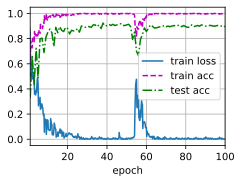

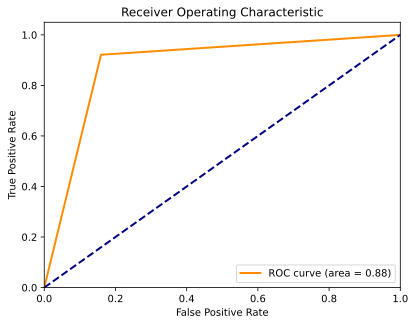

In [11]:
if __name__ == '__main__':
    main()